In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [15]:
def circle(n, x_offset=0, y_offset=0):

    t = np.linspace(0, 2*np.pi, n)

    x = np.cos(t) + np.random.normal(0,0.1,n) + x_offset
    y = np.sin(t) + np.random.normal(0,0.1,n) + y_offset
    
    return x, y

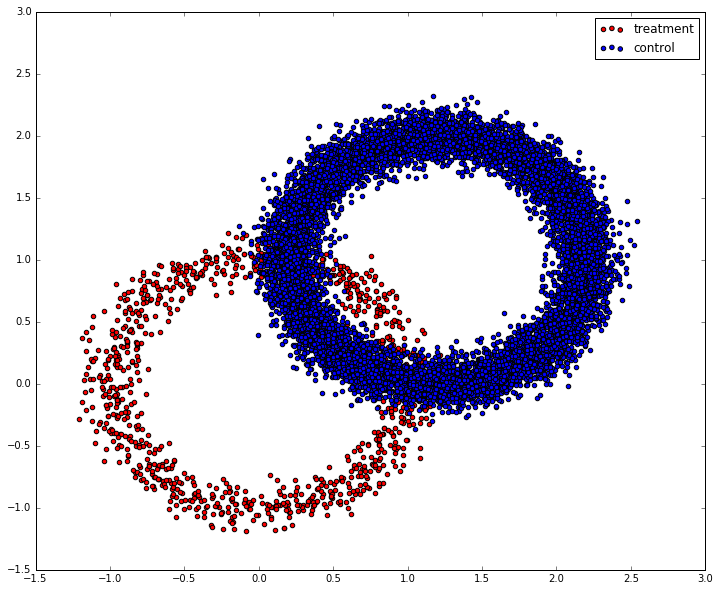

In [136]:
x1,y1 = circle(1000)
x2,y2 = circle(10000, 1.2, 1)

plt.scatter(x1, y1, c='r', label='treatment')
plt.scatter(x2, y2, c='b', label='control')

plt.legend()

In [106]:
X,Y = np.concatenate([x1,x2]), np.concatenate([y1,y2])

P = np.concatenate([np.ones(n), np.zeros(n)])

permutation = np.random.choice(len(P), len(P), replace=False)

X,Y,P = X[permutation], Y[permutation], P[permutation]

data = np.concatenate([np.expand_dims(X,axis=1), np.expand_dims(Y,axis=1)], axis=1)

In [111]:
def greedy_random_match(treatment, control, distances):

    # to account for len(control) < len(treatment)
    swapped = False
    if len(control) < len(treatment):
        swapped = True
        tmp = control
        control = treatment
        treatment = tmp
        distances = distances.T

    unmatched = list(range(len(control)))
    row_ind = []
    col_ind = []
    for i, (idx, row) in enumerate(treatment.sample(frac=1.).iterrows()):
        d = distances[i, unmatched]
        match_idx = np.argmin(d)
        match = unmatched[match_idx]
        col_ind.append(match)
        unmatched.remove(match)
    row_ind = list(range(len(treatment)))

    if swapped:
        tmp = row_ind
        row_ind = col_ind
        col_ind = tmp

    return row_ind, col_ind

# Matching Based on Propensity Score

In [107]:
import statsmodels.api as sm

In [108]:
model = sm.Logit(P, data)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.413975
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1998
Method:                           MLE   Df Model:                            1
Date:                Mon, 13 Feb 2017   Pseudo R-squ.:                  0.4028
Time:                        09:41:23   Log-Likelihood:                -827.95
converged:                       True   LL-Null:                       -1386.3
                                        LLR p-value:                7.790e-245
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.9847      0.063    -15.534      0.000        -1.109    -0.860
x2            -0.5940      0.082     -7.237      0.000        -0.755    -0.433
==============================================================================
"""

In [109]:
import pandas as pd

data1 = pd.DataFrame(np.concatenate([np.expand_dims(x1,axis=1), np.expand_dims(y1,axis=1)], axis=1))
data2 = pd.DataFrame(np.concatenate([np.expand_dims(x2,axis=1), np.expand_dims(y2,axis=1)], axis=1))

In [110]:
data1_propensity_scores = results.predict(data1)
data2_propensity_scores = results.predict(data2)

In [112]:
data2_propensity_scores

array([ 0.05900729,  0.05492999,  0.06146444, ...,  0.05344023,
        0.05401119,  0.05055735])

In [154]:
propensity_distances = np.array([
    abs(data2_propensity_scores - row_propensity)
    for row_propensity in data1_propensity_scores
])
propensity_distances

array([[ 0.20073706,  0.20481437,  0.19827991, ...,  0.20630412,
         0.20573317,  0.20918701],
       [ 0.25528743,  0.25936473,  0.25283027, ...,  0.26085449,
         0.26028353,  0.26373737],
       [ 0.25300754,  0.25708484,  0.25055039, ...,  0.2585746 ,
         0.25800364,  0.26145748],
       ..., 
       [ 0.21880207,  0.22287937,  0.21634492, ...,  0.22436913,
         0.22379817,  0.22725202],
       [ 0.21075501,  0.21483231,  0.20829786, ...,  0.21632207,
         0.21575111,  0.21920496],
       [ 0.22176096,  0.22583827,  0.21930381, ...,  0.22732802,
         0.22675707,  0.23021091]])

In [155]:
treatment_matches, control_matches = greedy_random_match(data1, data2, propensity_distances)

In [156]:
treatment = data1.iloc[treatment_matches].values
control = data2.iloc[control_matches].values

In [157]:
sample = np.random.choice(len(treatment), 100)

sampled_treatment = treatment[sample]
sampled_control = control[sample]

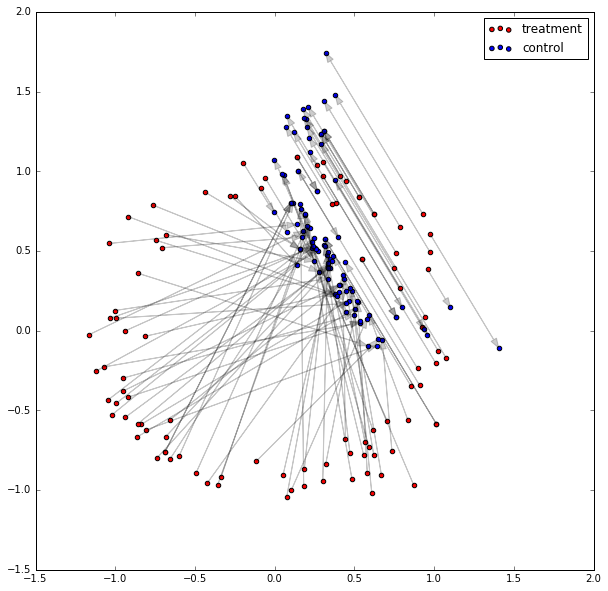

In [158]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

ax.scatter(sampled_treatment[:,0], sampled_treatment[:,1], c='r', label='treatment')
ax.scatter(sampled_control[:,0], sampled_control[:,1], c='b', label='control')

for i in range(len(sampled_treatment)):  
    ax.arrow(sampled_treatment[i,0], sampled_treatment[i,1], 
             sampled_control[i,0] - sampled_treatment[i,0], sampled_control[i,1] - sampled_treatment[i,1], 
             fc="k", ec="k", length_includes_head=True, alpha=0.2, head_width=.04)
    
ax.legend();

# Matching Based on Mahalanobis Distance

In [122]:
from scipy.spatial.distance import cdist

cov_distances = cdist(data1, data2, 'mahalanobis')

In [124]:
cov_treatment_matches, cov_control_matches = greedy_random_match(data1, data2, cov_distances)

In [125]:
cov_treatment = data1.iloc[cov_treatment_matches].values
cov_control = data2.iloc[cov_control_matches].values

In [126]:
cov_sample = np.random.choice(len(cov_treatment), 100)

sampled_cov_treatment = cov_treatment[cov_sample]
sampled_cov_control = cov_control[cov_sample]

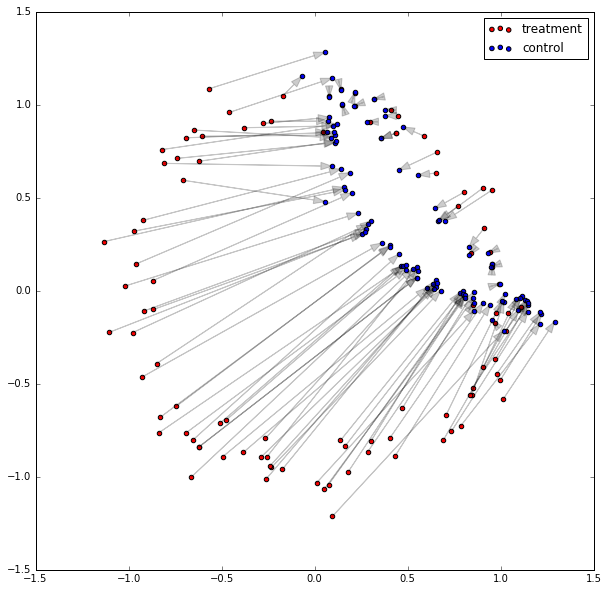

In [133]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

ax.scatter(sampled_cov_treatment[:,0], sampled_cov_treatment[:,1], c='r', label='treatment')
ax.scatter(sampled_cov_control[:,0], sampled_cov_control[:,1], c='b', label='control')

for i in range(len(sampled_cov_treatment)):  
    ax.arrow(sampled_cov_treatment[i,0], sampled_cov_treatment[i,1], 
             sampled_cov_control[i,0] - sampled_cov_treatment[i,0], sampled_cov_control[i,1] - sampled_cov_treatment[i,1], 
             fc="k", ec="k", length_includes_head=True, alpha=0.2, head_width=.04)
    
ax.legend()

# A Better Propensity Model Accounting for the Non-Linearity

In [209]:
(data**2).sum(axis=1).shape

(2000,)

In [229]:
def transform(data):
    d = np.expand_dims((data**2).sum(axis=1), axis=1)
    return np.concatenate([data, data**2, d], axis=1)

In [230]:
data_nonlinear = transform(data)
data_nonlinear.shape

(2000, 5)

In [231]:
model = sm.Logit(P, data_nonlinear)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.341570
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1996
Method:                           MLE   Df Model:                            3
Date:                Mon, 13 Feb 2017   Pseudo R-squ.:                  0.5072
Time:                        10:04:36   Log-Likelihood:                -683.14
converged:                       True   LL-Null:                       -1386.3
                                        LLR p-value:                1.258e-304
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -1.1846      0.096    -12.332      0.000        -1.373    -0.996
x2            -1.2215      0.132     -9.239      0.000        -1.481    -0.962
x3            -1.1055   1.36e+06  -8.14e-07      1.000     -2.66e+06  2.66e+06
x4             1.5941   1.36e+06   1.17e-06      1.000     -2.66e+06  2.66e+06
x5             0.4885   1.36e+06    3.6e-07      1.000     -2.66e+06  2.66e+06
==============================================================================
"""

In [239]:
data1_nonlinear_propensity_scores = results.predict(transform(data1))
data2_nonlinear_propensity_scores = results.predict(transform(data2))

In [240]:
nonlinear_propensity_distances = np.array([
    abs(data2_nonlinear_propensity_scores - row_propensity)
    for row_propensity in data1_nonlinear_propensity_scores
])

In [241]:
nonlinear_propensity_distances.shape

(1000, 10000)

In [242]:
data1.shape, data2.shape

((1000, 2), (10000, 2))

In [243]:
treatment_matches, control_matches = greedy_random_match(data1, data2, nonlinear_propensity_distances)

In [244]:
treatment = data1.iloc[treatment_matches].values
control = data2.iloc[control_matches].values

In [245]:
sample = np.random.choice(len(treatment), 100)

sampled_treatment = treatment[sample]
sampled_control = control[sample]

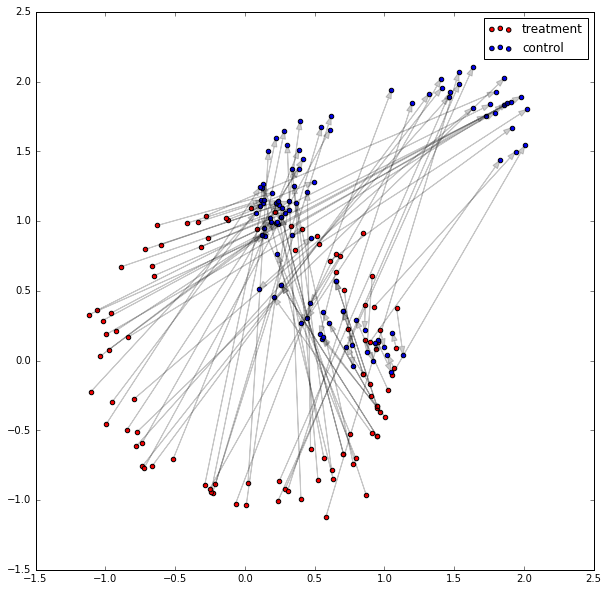

In [246]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

ax.scatter(sampled_treatment[:,0], sampled_treatment[:,1], c='r', label='treatment')
ax.scatter(sampled_control[:,0], sampled_control[:,1], c='b', label='control')

for i in range(len(sampled_treatment)):  
    ax.arrow(sampled_treatment[i,0], sampled_treatment[i,1], 
             sampled_control[i,0] - sampled_treatment[i,0], sampled_control[i,1] - sampled_treatment[i,1], 
             fc="k", ec="k", length_includes_head=True, alpha=0.2, head_width=.04)
    
ax.legend();